**calculate heat- and mass-tranfer coefficient with log-mean-temperature difference**

$Q = \alpha * A * \Delta T$\
when counter current:\
$\Delta T = \frac{(T_{a,i} - T_{d,o}) - (T_{a,o} - T_{d,i})}{ln(T_{a,i} - T_{d,o})-ln(T_{a,o} - T_{d,i})}$

similar calculation for mass difference, the equivalent state of air over the surface of desiccant is used

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sys.path.insert(0, os.path.join('.','..','..','calibration'))
from thermodynamics import *

# import code of mathieu
import media_model_mgcl2 as model_mg
import media_model_water as model_w

# define functions needed

In [5]:
calc_Q_d_h = lambda m, T, xi: m * model_mg.h_MgCl2(T= T, xi = xi) * 1000

In [6]:
def df_preproc(df, type_des = "MgCl2", calc_m_balance = False):
    df["m_a_cond"] = df.m_a_in * (df.x_a_in - df.x_a_o_exp)
    df_result = df.copy()
    df_result = prepare_for_h_m(df_result, type_des=type_des)
    
    df_result["delta_Q_d_h"] = np.vectorize(calc_Q_d_h)(df_result.m_d_in + df_result.m_a_cond, df_result.T_d_o_exp, df_result.xi_d_in) - \
                                    np.vectorize(calc_Q_d_h)(df_result.m_d_in, df_result.T_d_in, df_result.xi_d_in)
    df_result["h_d_in"] = np.vectorize(model_mg.h_MgCl2)(df_result.T_d_in, df_result.xi_d_in) * 1000
    df_result["h_d_out"] = np.vectorize(model_mg.h_MgCl2)(df_result.T_d_o_exp, df_result.xi_d_in) * 1000
    
    if calc_m_balance:
        df_result = df_result[["cp_d", "h_d_in", "h_d_out", "delta_Q_d", "delta_Q_d_h", \
                           "m_d_in", "m_a_cond", "T_d_in", "T_d_o_exp", "delta_Q_a", "delta_m_des", "delta_m_a"]]
    else:
        df_result = df_result[["cp_d", "h_d_in", "h_d_out", "delta_Q_d", "delta_Q_d_h", \
                           "m_d_in", "m_a_cond", "T_d_in", "T_d_o_exp", "delta_Q_a", ]]
    return df_result

In [7]:
def plot_compare_2_cols(col1, col2, deviation = 0.2, x_label = 'x', y_label = 'y', save_fig = None):
    fig, ax = plt.subplots(figsize=(6,6))

    max_v = max(col1)*1.2
    min_v = min(col1)*0.5
    x = np.linspace(min_v, max_v, 10)
    y1 = x* (1-deviation)
    y2 = x* (1+deviation)


    origin_line = ax.plot(x, x, c = 'black')
    min_dev = ax.plot(x, y1, c = 'black')
    max_dev = ax.plot(x, y2, c = 'black')
    data_point = ax.scatter(col1, col2)

    plt.xlim([min_v, max_v])
    plt.ylim([min_v, max_v])
    ax.set_xlabel(x_label, fontsize = 20)
    ax.set_ylabel(y_label, fontsize = 20)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=-45)
    fig.tight_layout()
    
    if save_fig is not None:
        fig.savefig('{}.png'.format(save_fig), dpi=300)
    return

# check heat balance

In [11]:
# path of the measurement data
path_exp = os.path.join(os.path.expanduser('~'), 'GIT', 'TheGreeFa_EnBA', 'Data_input', 'measurement')

## check heat balance and plot

### chen2016

In [13]:
df_chen = pd.read_excel(os.path.join(path_exp, 'actual_data_converted', 'Chen2016.xlsx'), index_col=0)
df_chen_compare = df_preproc(df_chen, type_des='LiCl', calc_m_balance=True)

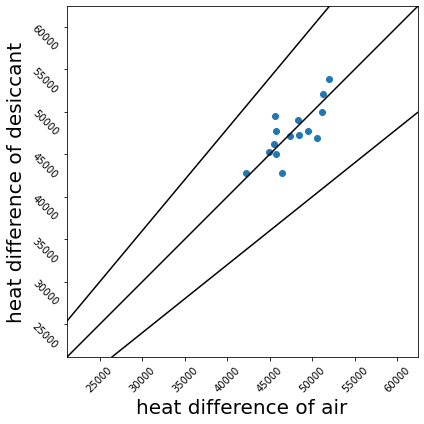

In [14]:
plot_compare_2_cols(df_chen_compare.delta_Q_a, df_chen_compare.delta_Q_d, \
                    x_label='heat difference of air', y_label='heat difference of desiccant', save_fig="chen_hb")

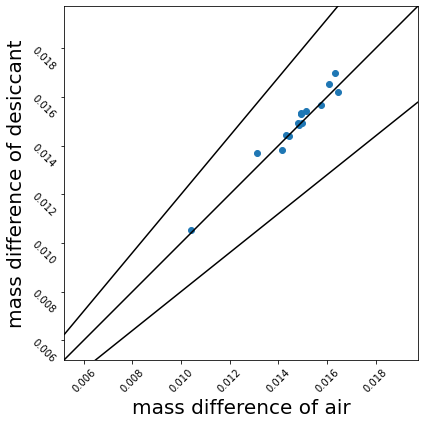

In [15]:
plot_compare_2_cols(df_chen_compare.delta_m_a, df_chen_compare.delta_m_des, \
                    x_label='mass difference of air', y_label='mass difference of desiccant', save_fig="chen_mb")

### teststand

In [16]:
df_teststand = pd.read_excel(os.path.join(path_exp, 'actual_data_converted', 'teststand_with_additional_columns.xlsx'), index_col= 0)
df_teststand.head()

,T_a_in,RH_a_in,x_a_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,RH_a_o_exp,T_d_o_exp,x_a_o_exp,x_d_in_equ
0,297.04,87.20,0.016362,46.52,0.014969,298.21,0.313764,1.31,1292.0,0.028209,301.27,51.24,298.84,0.012271,0.009253
1,299.92,79.81,0.017815,47.22,0.015014,300.91,0.311185,1.28,1289.0,0.027499,303.40,50.93,301.59,0.013828,0.011082
2,299.94,83.82,0.018759,19.50,0.006191,300.29,0.314032,1.18,1292.0,0.025409,303.52,49.44,300.98,0.013509,0.010496
3,300.49,75.69,0.017460,18.49,0.005871,301.85,0.312199,0.75,1290.0,0.016125,304.04,46.88,302.48,0.013190,0.011662
4,301.58,86.59,0.021418,18.90,0.005943,303.40,0.312333,0.22,1290.0,0.004730,306.72,49.14,304.58,0.016161,0.012790


In [17]:
df_teststand_compare = df_preproc(df_teststand, type_des='MgCl2')

not possible to compute mass difference of solution.


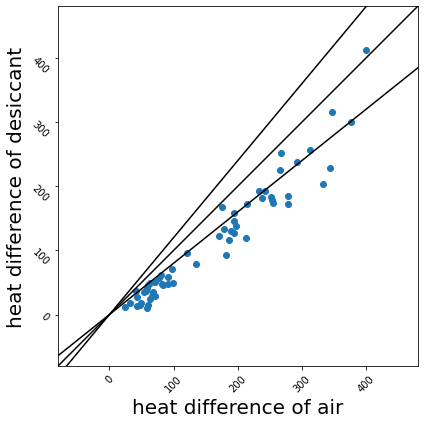

In [18]:
plot_compare_2_cols(df_teststand_compare.delta_Q_a, df_teststand_compare.delta_Q_d, \
                    x_label='heat difference of air', y_label='heat difference of desiccant', save_fig="teststand_hb")

### dempav

In [ ]:
df_dempav

not possible to compute mass difference of solution.


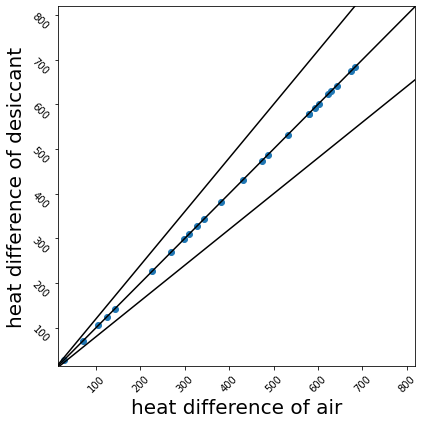

In [21]:
df_dempav = pd.read_excel(os.path.join(path_exp, 'actual_data_converted', 'dempav_T_des_corrected.xlsx'), index_col=0)
df_dempav_compare = df_preproc(df_dempav, type_des='MgCl2')
plot_compare_2_cols(df_dempav_compare.delta_Q_a, df_dempav_compare.delta_Q_d, \
                    x_label='heat difference of air', y_label='heat difference of desiccant', save_fig="dempav_hb")

### ZHAW HDisNet

In [22]:
df_zhaw = pd.read_excel(os.path.join(path_exp, 'actual_data_converted', 'ZHAW_data.xlsx'), index_col=0)

In [23]:
df_zhaw.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp
1,305.65,0.0170,0.27,289.55,0.33,0.62,293.45,0.0063,296.15
2,305.65,0.0170,0.27,290.15,0.33,0.62,294.05,0.0065,296.55
3,305.65,0.0230,0.27,292.65,0.33,0.62,296.25,0.0063,299.15
4,306.65,0.0224,0.27,295.45,0.34,0.63,298.55,0.0086,301.65
5,307.05,0.0233,0.27,297.85,0.34,0.63,300.05,0.0093,303.75


In [24]:
df_zhaw_compare = df_preproc(df_zhaw, type_des='MgCl2')

not possible to compute mass difference of solution.


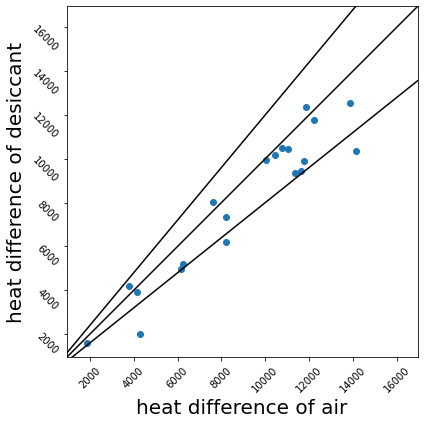

In [25]:
plot_compare_2_cols(df_zhaw_compare.delta_Q_a, df_zhaw_compare.delta_Q_d, \
                    x_label='heat difference of air', y_label='heat difference of desiccant', save_fig="zhaw_hdisnet_hb")

### ZHAW V3

In [27]:
df_v3 = pd.read_excel(os.path.join(path_exp, 'raw_exp_data_unconverted', 'ZHAW', 'V3.xlsm'), sheet_name="CLEAN DATA", index_col = 0)

In [28]:
df_v3 = df_v3.reset_index().drop(columns = ["index"])

In [29]:
df_v3.rename(columns={"x_a_o_oxp":"x_a_o_exp"}, inplace=True)

In [30]:
df_v3.head()

,T_a_in,x_a_in,V_a_in,T_d_in,xi_d_in,V_d_in,x_a_o_exp,T_a_o_exp,T_d_o_exp-sumpf,xi_d_o_exp,hr_air_in,hr_air_out
0,28.814381,12.403561,746.97,29.885721,0.264417,0.812814,17.454089,30.582320,27.909622,NaN,49.089193,62.125076
1,28.841848,12.422761,746.40,29.941734,0.264427,0.812909,17.490910,30.585805,27.891535,NaN,49.083864,62.243172
2,28.864600,12.473257,743.55,29.991469,0.264436,0.813538,17.530388,30.598311,27.873725,NaN,49.215855,62.337076
3,28.838773,12.478598,741.84,30.034803,0.264444,0.812985,17.491955,30.598721,27.855208,NaN,49.313619,62.198886
4,28.748173,12.317790,740.70,30.072136,0.264451,0.815569,17.591520,30.677652,27.836076,NaN,48.944700,62.258755


In [31]:
calc_m_from_v = lambda T, RH: 1/HAPropsSI("Vda",'T',T,'P',101325,'R',RH)

In [32]:
df_v3_converted = df_v3.copy()

In [33]:
df_v3_converted["T_a_in"] = df_v3.T_a_in + 273.15
df_v3_converted["T_a_o_exp"] = df_v3["T_d_o_exp-sumpf"] + 273.15

In [34]:
df_v3_converted["T_d_in"] = df_v3.T_d_in + 273.15
df_v3_converted["T_d_o_exp"] = df_v3.T_a_o_exp + 273.15

df_v3_converted["hr_air_in"] = df_v3.hr_air_in/100
df_v3_converted["hr_air_out"] = df_v3.hr_air_out/100

In [35]:
df_v3_converted["m_a_in"] = np.vectorize(calc_m_from_v)(df_v3_converted.T_a_in, df_v3_converted.hr_air_in) * df_v3_converted.V_a_in/3600

In [36]:
df_v3_converted["x_a_in"] = np.vectorize(get_x)(df_v3_converted.T_a_in, df_v3_converted.hr_air_in)

In [37]:
df_v3_converted["x_a_o_exp"] = np.vectorize(get_x)(df_v3_converted.T_a_o_exp, df_v3_converted.hr_air_out)

In [38]:
df_v3_converted["m_d_in"] = np.vectorize(model_mg.rho_MgCl2)(df_v3_converted.T_d_in, df_v3_converted.xi_d_in)*df_v3_converted.V_d_in/1000

In [39]:
df_v3_sampled = df_v3_converted.sample(1000)

In [40]:
df_v3_sampled.head()

,T_a_in,x_a_in,V_a_in,T_d_in,xi_d_in,V_d_in,x_a_o_exp,T_a_o_exp,T_d_o_exp-sumpf,xi_d_o_exp,hr_air_in,hr_air_out,T_d_o_exp,m_a_in,m_d_in
17807,302.129388,0.019936,757.80,302.487032,0.259413,0.221114,0.016930,302.169472,29.019472,NaN,0.782490,0.666109,301.712307,0.238395,0.273076
15010,302.276152,0.019687,749.82,302.153769,0.260337,0.372033,0.016833,302.152703,29.002703,NaN,0.766485,0.663017,301.685245,0.235861,0.459833
9177,302.298084,0.019801,746.40,302.322781,0.262330,0.540720,0.016662,302.190242,29.040242,NaN,0.769801,0.655033,301.788162,0.234727,0.669411
2921,302.202770,0.020007,748.11,302.315642,0.263309,0.811344,0.016643,302.155164,29.005164,NaN,0.781879,0.655653,301.480845,0.235263,1.005255
3217,302.237821,0.020346,745.83,302.145831,0.263279,0.813326,0.016671,302.168672,29.018672,NaN,0.793076,0.656204,301.448042,0.234396,1.007711


In [41]:
df_v3_compare = df_preproc(df_v3_sampled, type_des='MgCl2')

In [42]:
df_v3_compare.head()

,cp_d,h_d_in,h_d_out,delta_Q_d,delta_Q_d_h,m_d_in,m_a_cond,T_d_in,T_d_o_exp,delta_Q_a
17807,2.853955,-297718.791055,-299959.769548,-603.778824,-826.862285,0.273076,0.000716,302.487032,301.712307,1818.647583
15010,2.849742,-299993.505152,-301346.760219,-613.956209,-825.112950,0.459833,0.000673,302.153769,301.685245,1748.418700
9177,2.841815,-302329.854899,-303869.351950,-1017.028833,-1254.424462,0.669411,0.000737,302.322781,301.788162,1906.852746
2921,2.837814,-303735.924977,-306136.062483,-2381.448267,-2655.017496,1.005255,0.000791,302.315642,301.480845,2031.540457
3217,2.837713,-304182.566310,-306188.813678,-1995.393186,-2285.428426,1.007711,0.000861,302.145831,301.448042,2215.193661


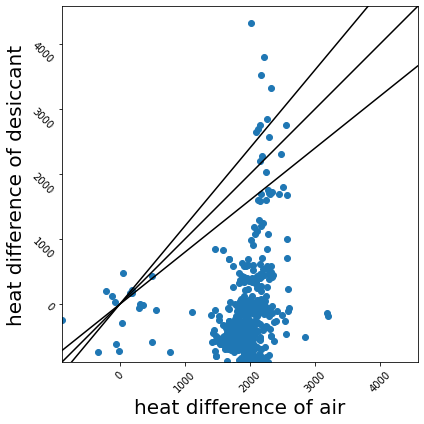

In [43]:
plot_compare_2_cols(df_v3_compare.delta_Q_a, df_v3_compare.delta_Q_d, \
                    x_label='heat difference of air', y_label='heat difference of desiccant', save_fig="zhaw_BA19_hb")

## check the difference calculating desiccant energy difference using cp and h

***the mass flow rate of air condensation $m_{cond}$ also made a big difference!***

# Exp Data h&m calculation

## **Chen 2016 data**

In [45]:
df_chen = pd.read_excel(os.path.join(path_exp, 'actual_data_converted', 'Chen2016.xlsx'), index_col=0)#.drop(columns = ['w_air_in', 'w_air_out'])

In [46]:
df_chen = prepare_for_h_m(df_chen, type_des="LiCl")

In [47]:
df_result_chen = calc_heat_exchange(df_chen, exchange_area = 450*1.75*0.75*0.75, d_e=0.01, flow_config='cross')

In [48]:
df_result_chen = calc_mass_exchange(df_result_chen, 
                   exchange_area = 450*1.75*0.75*0.75, 
                   d_e=0.01, 
                   type_d='LiCl',
                   flow_config='cross')

In [49]:
df_result_chen.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp,xi_d_o_exp,...,delta_Q_sen,log_m_delta_T,h_c,Nu_2,log_m_delta_x,h_d,Sh_2,cp_a,Le,alpha
1,298.75,0.0162,1.85,288.05,0.230,2.61,292.35,0.0091,294.45,0.2288,...,11913.442483,3.870000,6.949495,2.669249,0.003889,0.007624,2.612603,1030.113086,0.884835,7.853998
2,301.75,0.0202,1.87,291.35,0.240,2.63,296.05,0.0116,298.35,0.2385,...,10726.330598,3.613486,6.701187,2.550567,0.005332,0.006809,2.317401,1036.424784,0.949617,7.056726
3,300.65,0.0181,1.92,290.85,0.255,2.65,295.05,0.0099,297.45,0.2535,...,10819.522620,3.309630,7.379986,2.816781,0.004539,0.007830,2.667935,1032.757794,0.912621,8.086585
4,303.15,0.0177,1.89,292.05,0.260,2.66,296.65,0.0097,298.95,0.2585,...,12363.045597,3.957271,7.052719,2.676548,0.003810,0.008960,3.042068,1032.245801,0.762573,9.248579
5,300.75,0.0164,1.92,290.45,0.270,2.67,294.75,0.0087,296.85,0.2685,...,11592.307658,3.687071,7.097661,2.709514,0.004043,0.008255,2.812616,1029.985142,0.834737,8.502875


In [50]:
cp_a = lambda T, W: HAPropsSI('C', 'T', T, 'W', W, 'P', 101325)
df_result_chen['cp_a'] = np.vectorize(cp_a)(df_result_chen.T_a_in, df_result_chen.x_a_in)

In [51]:
df_result_chen['Le'] = df_result_chen.h_c / df_result_chen.h_d / df_result_chen.cp_a

In [9]:
# df_result_chen.to_excel('Nu_Sh_overall_transfer_coeff_2.xlsx')

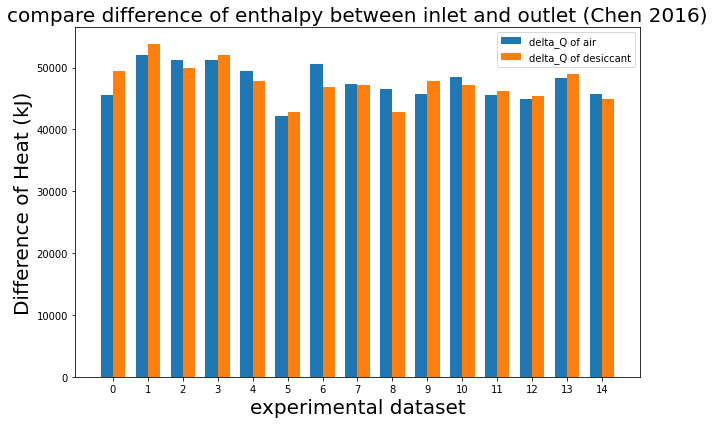

In [52]:
df = df_result_chen
fig, ax = plt.subplots(figsize=(9,6))

width = 0.35
x = np.arange(df.shape[0])

rects1 = ax.bar(x-width/2, df.delta_Q_a, width, label='delta_Q of air')
rects2 = ax.bar(x+width/2, df.delta_Q_d, width, label='delta_Q of desiccant')

ax.set_ylabel('Difference of Heat (kJ)', fontsize = 20)
ax.set_xlabel('experimental dataset', fontsize = 20)
ax.set_title('compare difference of enthalpy between inlet and outlet (Chen 2016)', fontsize = 20)
ax.set_xticks(x)
# ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
# plt.savefig('difference Chen2016.png', dpi=300)

## **Teststand data**

In [6]:
# read experimental data
df_teststand = pd.read_excel("../exp_data/actual_data/teststand_cool_5.xlsx", index_col=0) #.drop(columns = ['w_air_in', 'w_air_out'])
df_teststand = prepare_for_h_m(df_teststand)
df_teststand.head()

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,...,x_d_in_equ,rho_da,rho_ha,k,m_da,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d
46,319.15,0.4123,20.96,0.006175,282.98,0.313366,1.36,1287.06,0.029173,304.94,...,0.003439,1.060667,1.089088,0.027213,0.006175,115561.987782,76949.803353,238.447266,2.612939,181.423125
47,315.48,0.3369,33.23,0.010043,283.15,0.309459,1.39,1284.00,0.029746,302.44,...,0.003560,1.087974,1.107401,0.027010,0.010043,88638.407335,64449.435772,242.920300,2.628220,193.102191
48,314.19,0.3195,57.72,0.017573,284.92,0.305991,1.45,1280.68,0.030950,303.40,...,0.004097,1.096016,1.113299,0.027000,0.017573,81920.595949,64133.699552,312.565310,2.644200,256.150960
49,312.47,0.3218,79.51,0.024390,286.62,0.301129,1.50,1276.00,0.031900,303.46,...,0.004722,1.104321,1.120291,0.026942,0.024390,76774.655675,62540.128968,347.182178,2.665546,316.315070
50,312.94,0.3915,51.48,0.015678,280.02,0.310692,0.81,1286.00,0.017361,304.45,...,0.002843,1.096331,1.116226,0.026986,0.015678,86743.045121,70482.442061,254.926180,2.618992,174.598350


In [7]:
df_result_teststand = calc_heat_exchange(df_teststand.copy(), exchange_area=1.274, d_e=0.0399)

df_result_teststand.head()

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,...,m_da,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d,delta_Q_sen,log_m_delta_T,h_c,Nu_2
46,319.15,0.4123,20.96,0.006175,282.98,0.313366,1.36,1287.06,0.029173,304.94,...,0.006175,115561.987782,76949.803353,238.447266,2.612939,181.423125,88.354772,27.451472,2.526358,3.704141
47,315.48,0.3369,33.23,0.010043,283.15,0.309459,1.39,1284.00,0.029746,302.44,...,0.010043,88638.407335,64449.435772,242.920300,2.628220,193.102191,131.835366,24.191354,4.277621,6.319028
48,314.19,0.3195,57.72,0.017573,284.92,0.305991,1.45,1280.68,0.030950,303.40,...,0.017573,81920.595949,64133.699552,312.565310,2.644200,256.150960,190.882497,22.089083,6.782956,10.023575
49,312.47,0.3218,79.51,0.024390,286.62,0.301129,1.50,1276.00,0.031900,303.46,...,0.024390,76774.655675,62540.128968,347.182178,2.665546,316.315070,221.221495,19.364724,8.966988,13.279896
50,312.94,0.3915,51.48,0.015678,280.02,0.310692,0.81,1286.00,0.017361,304.45,...,0.015678,86743.045121,70482.442061,254.926180,2.618992,174.598350,133.994517,26.687517,3.941027,5.827067


In [9]:
df_result_teststand = calc_mass_exchange(df_result_teststand, exchange_area=1.274, d_e=0.0399)

In [20]:
df_result_teststand.rename(columns={'h_d': 'beta'}, inplace=True)

In [24]:
df_result_teststand

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,...,log_m_delta_T,h_c,Nu_2,delta_m_a,log_m_delta_x,beta,Sh_2,cp_a,Le,alpha
46,319.15,0.4123,20.96,0.006175,282.98,0.313366,1.36,1287.06,0.029173,304.94,...,27.451472,2.526358,3.704141,0.000057,0.018103,0.002469,3.310341,1048.901946,0.975475,2.589875
47,315.48,0.3369,33.23,0.010043,283.15,0.309459,1.39,1284.00,0.029746,302.44,...,24.191354,4.277621,6.319028,0.000042,0.011804,0.002778,3.724841,1036.527093,1.485594,2.879401
48,314.19,0.3195,57.72,0.017573,284.92,0.305991,1.45,1280.68,0.030950,303.40,...,22.089083,6.782956,10.023575,0.000045,0.009879,0.003608,4.816549,1034.044608,1.818090,3.730813
49,312.47,0.3218,79.51,0.024390,286.62,0.301129,1.50,1276.00,0.031900,303.46,...,19.364724,8.966988,13.279896,0.000047,0.008117,0.004540,6.050032,1032.150550,1.913709,4.685660
50,312.94,0.3915,51.48,0.015678,280.02,0.310692,0.81,1286.00,0.017361,304.45,...,26.687517,3.941027,5.827067,0.000046,0.013393,0.002667,3.553171,1038.270770,1.423154,2.769220
51,319.85,0.3707,33.24,0.009801,278.88,0.312583,0.80,1286.00,0.017147,306.66,...,32.097170,3.183127,4.651952,0.000055,0.018939,0.002296,3.061992,1048.723625,1.321793,2.408188
52,326.57,0.4287,21.44,0.006039,279.10,0.307317,0.88,1278.00,0.018744,310.49,...,36.737341,2.089806,3.016966,0.000073,0.031610,0.001807,2.413071,1074.160642,1.076809,1.940740
53,314.95,0.4256,50.21,0.015100,279.72,0.299305,0.85,1273.40,0.018040,305.99,...,28.088957,3.806518,5.603583,0.000049,0.016821,0.002290,3.047126,1045.532986,1.590089,2.393903
54,315.72,0.5586,35.98,0.010654,283.17,0.324059,0.89,1299.53,0.019276,308.06,...,26.625568,2.422442,3.555929,0.000096,0.022031,0.003429,4.561663,1056.341590,0.668699,3.622620
55,312.81,0.5102,53.28,0.016094,283.18,0.312543,0.98,1288.00,0.021037,306.12,...,24.187777,3.517480,5.193183,0.000090,0.016716,0.004235,5.633063,1046.317895,0.793877,4.430760


In [23]:
# df_result_teststand[col_a_b.to_list()].to_excel('../exp_data/simulation_input/teststand_cool_5_a_b.xlsx')

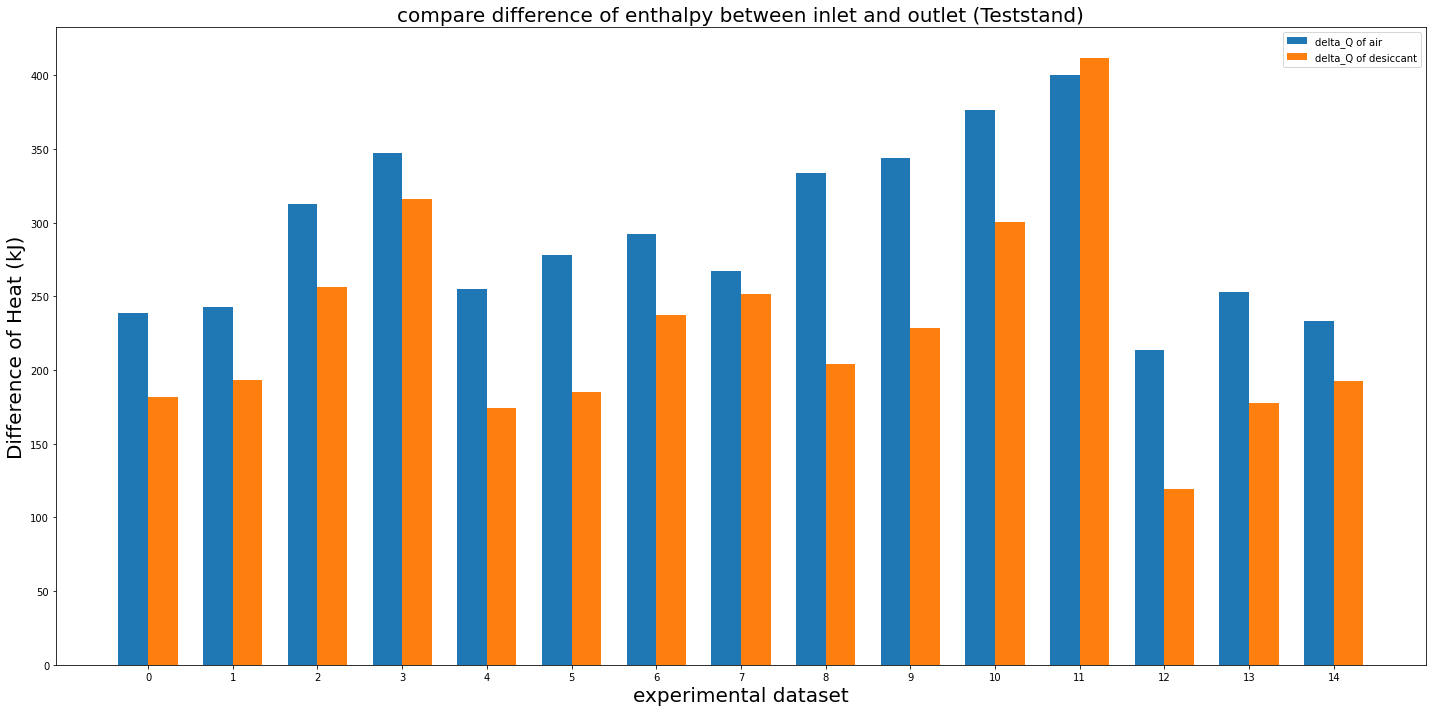

In [11]:
df = df_teststand
fig, ax = plt.subplots(figsize=(20,10))

width = 0.35
x = np.arange(df.shape[0])

rects1 = ax.bar(x-width/2, df.delta_Q_a, width, label='delta_Q of air')
rects2 = ax.bar(x+width/2, df.delta_Q_d, width, label='delta_Q of desiccant')

ax.set_ylabel('Difference of Heat (kJ)', fontsize = 20)
ax.set_xlabel('experimental dataset', fontsize = 20)
ax.set_title('compare difference of enthalpy between inlet and outlet (Teststand)', fontsize = 20)
ax.set_xticks(x)
# ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
# plt.savefig('difference Teststand.png', dpi=300)

## **ZHAW data**

In [3]:
df_ZHAW = pd.read_excel("../exp_data/actual_data/ZHAW_data.xlsx", index_col=0)

In [4]:
df_ZHAW = prepare_for_h_m(df_ZHAW)

In [5]:
df_result_ZHAW = calc_heat_exchange(df_ZHAW, exchange_area=350*1.5*0.5*0.5/4*math.pi, d_e=0.015)

In [6]:
df_result_ZHAW

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp,hr_air_in,...,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d,x_d_in_equ,delta_Q_sen,log_m_delta_T,h_c,Nu_2
1,305.65,0.0170,0.27,289.55,0.33,0.62,293.45,0.0063,296.15,0.548211,...,76219.061714,36407.515359,10749.117516,2.561175,10480.326080,0.004828,3314.896615,6.289907,5.112538,2.912625
2,305.65,0.0170,0.27,290.15,0.33,0.62,294.05,0.0065,296.55,0.548211,...,76219.061714,37526.002143,10447.126084,2.562190,10166.771758,0.005021,3151.901300,6.137157,4.982143,2.836026
3,305.65,0.0230,0.27,292.65,0.33,0.62,296.25,0.0063,299.15,0.734798,...,91572.206101,39257.981540,14124.840631,2.566448,10342.785628,0.005904,2554.225221,4.908031,5.048504,2.866224
4,306.65,0.0224,0.27,295.45,0.34,0.63,298.55,0.0086,301.65,0.677171,...,91086.184133,47457.338566,11779.788303,2.535596,9904.037692,0.006612,2201.115730,3.974598,5.372303,3.036454
5,307.05,0.0233,0.27,297.85,0.34,0.63,300.05,0.0093,303.75,0.687849,...,93810.958385,50775.757385,11619.504270,2.539895,9440.788757,0.007682,1902.267310,2.712934,6.802102,3.835139
6,297.95,0.0155,0.30,300.65,0.35,0.60,300.25,0.0096,303.45,0.783264,...,64404.900412,51745.470934,3797.828843,2.510411,4217.489881,0.008528,-694.362854,-1.945793,3.461789,1.975272
7,297.65,0.0154,0.30,303.55,0.35,0.63,302.95,0.0108,304.55,0.792422,...,63839.806374,57577.409689,1878.719005,2.515779,1584.941070,0.010159,-1600.123520,-2.579486,6.017708,3.422719
8,306.35,0.0201,0.27,290.75,0.30,0.65,293.95,0.0079,297.85,0.620153,...,84883.293111,40977.585659,11854.541012,2.675947,12349.494199,0.006238,3369.312398,5.425240,6.024668,3.427083
9,306.45,0.0207,0.27,293.15,0.30,0.65,295.75,0.0090,299.15,0.634501,...,86523.973093,45611.007948,11046.500589,2.679511,10450.094758,0.007281,2907.487735,4.552663,6.195313,3.515270
10,306.95,0.0220,0.22,298.35,0.30,0.65,299.45,0.0115,302.95,0.654425,...,90376.477339,55767.369195,7614.003792,2.687373,8035.245179,0.010092,1660.687438,2.246348,7.171692,4.046899


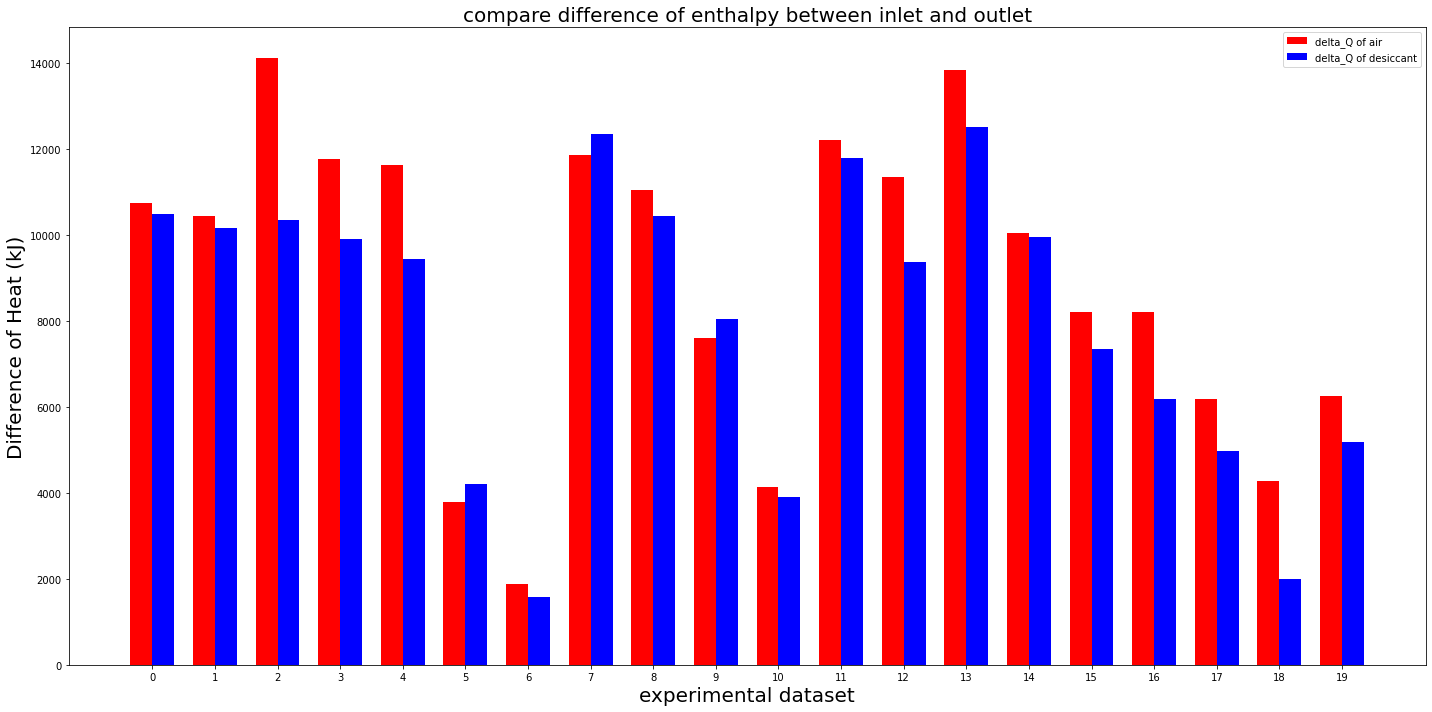

In [7]:
df = df_result_ZHAW
fig, ax = plt.subplots(figsize=(20,10))

width = 0.35
x = np.arange(df.shape[0])

rects1 = ax.bar(x-width/2, df.delta_Q_a, width, label='delta_Q of air', color = 'red')
rects2 = ax.bar(x+width/2, df.delta_Q_d, width, label='delta_Q of desiccant', color = 'blue')

ax.set_ylabel('Difference of Heat (kJ)', fontsize = 20)
ax.set_xlabel('experimental dataset', fontsize = 20)
ax.set_title('compare difference of enthalpy between inlet and outlet', fontsize = 20)
ax.set_xticks(x)
# ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

## **dempav**

In [3]:
df_dempav = pd.read_excel("../exp_data/EnBA_M_selected_data.xlsx", sheet_name='dempav_cool', index_col=0)

In [4]:
df_dempav = prepare_for_h_m(df_dempav, type_des='MgCl2')
df_dempav.head()

,T_a_in,hr_air_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,...,rho_da,rho_ha,k,m_da,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d,x_d_in_equ
0,298.02,0.480462,0.018848,287.44,0.318302,0.102670,290.21,0.476947,286.230,0.009457,...,1.167162,1.178200,0.025937,0.018848,49097.449796,31774.623096,326.495736,2.601039,-323.130317,0.004515
1,300.51,0.553303,0.036283,292.20,0.318186,0.102670,294.81,0.538242,290.092,0.012683,...,1.151599,1.166205,0.026193,0.036283,59874.298508,43928.255277,578.564508,2.609102,-564.681931,0.006170
2,298.02,0.458659,0.032644,284.16,0.318572,0.102670,287.98,0.506137,281.766,0.009022,...,1.167964,1.178501,0.025856,0.032644,47989.141388,28332.594775,641.676835,2.594899,-637.808331,0.003614
3,301.31,0.504712,0.036150,290.94,0.318174,0.102669,293.69,0.519635,288.468,0.012112,...,1.149564,1.163488,0.026183,0.036150,59240.808747,40570.888880,674.917727,2.607111,-661.678132,0.005687
4,299.87,0.423994,0.045742,290.34,0.318171,0.102668,292.89,0.525218,288.366,0.009311,...,1.160209,1.171011,0.026104,0.045742,50619.147152,38987.326200,532.063750,2.606157,-528.181465,0.005470


In [5]:
df_result_dempav = calc_heat_exchange(df_dempav, exchange_area=6.495, d_e=0.0399)

In [6]:
df_result_dempav = calc_mass_exchange(df_dempav, exchange_area=6.495, d_e=0.0399)

In [11]:
df_result_dempav.columns

Index(['T_a_in', 'hr_air_in', 'm_a_in', 'T_d_in', 'xi_d_in', 'm_d_in',
       'T_a_o_exp', 'hr_air_out', 'T_d_o_exp', 'x_a_in', 'x_a_o_exp', 'rho_da',
       'rho_ha', 'k', 'm_da', 'h_a_in', 'h_a_out', 'delta_Q_a', 'cp_d',
       'delta_Q_d', 'x_d_in_equ', 'delta_Q_sen', 'log_m_delta_T', 'h_c',
       'Nu_2', 'delta_m_a', 'log_m_delta_x', 'h_d', 'Sh_2', 'cp_a', 'Le'],
      dtype='object')

In [8]:
df_result_dempav['cp_a'] = np.vectorize(get_cp_a)((df_result_dempav['T_a_in']+df_result_dempav.T_a_o_exp)/2, (df_result_dempav.x_a_in+df_result_dempav.x_a_o_exp)/2)

In [9]:
df_result_dempav['Le'] = df_result_dempav.h_c/df_result_dempav.cp_a/df_result_dempav.h_d

In [12]:
df_result_dempav['alpha'] = df_result_dempav['cp_a'] * df_result_dempav['h_d']

In [14]:
# df_result_dempav.to_excel('dempav_calc_beta_alpha.xlsx')